In [1]:
import h5py
import numpy as np
import tensorflow as tf
import os
import time
import glob
import Next_batch
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

C:\Users\Robotmedia9\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
c_dim=3
learning_rate=1e-4
stddev=1e-3
scale=2
image_size=120
label_size=120



In [3]:
# x_data=[]
# y_data=[]
# image_data=[]#training data load 
# image_test=[]#training data load 

# for i in glob.glob("./Train/*.bmp"):# load image data
#     n=cv2.imread(i,cv2.IMREAD_COLOR)
#     n=cv2.cvtColor(n, cv2.COLOR_BGR2RGB)# matplotlib = RGB channel , opencv = BGR channels
#     image_data.append(n)
# for i in range(len(image_data)):
#     tmp_image=image_data[i]
#     size = tmp_image.shape    # image size
#     height, width = size[:2]      # height ,width
#     tmp_X=cv2.resize(tmp_image,None,fx=1/scale,fy=1/scale)
# #     tmp_blur=cv2.GaussianBlur(tmp_X,(3,3),0)
# #     sub_X=cv2.resize(tmp_X,None,fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC)
#     sub_X=cv2.resize(tmp_X,(image_size, image_size),interpolation=cv2.INTER_CUBIC)
#     sub_Y=cv2.resize(tmp_image,(label_size, label_size),interpolation=cv2.INTER_CUBIC)
    
#     x_data.append(sub_X)
#     y_data.append(sub_Y)


In [4]:
with h5py.File("D:/h5_image_data/training_image.h5", 'r') as hf:
    x_data = np.array(hf.get('data'))
    y_data = np.array(hf.get('label'))

(120, 120, 3) (120, 120, 3)


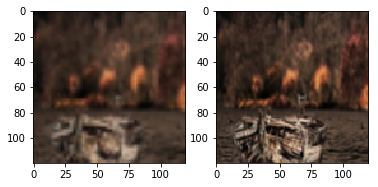

In [5]:
plt.subplot(1, 2, 1) # 1행 2열에서 1번째 열
plt.imshow(x_data[0])
print(x_data[0].shape,y_data[0].shape)
plt.subplot(1, 2, 2) # 1행 2열에서 1번째 열
plt.imshow(y_data[0])

In [6]:
images=tf.placeholder(tf.float32,[None,image_size,image_size,c_dim],name='images')
labels=tf.placeholder(tf.float32,[None,label_size,label_size,c_dim],name='labels')
        
#parameter
#9*9
w9_1=tf.Variable(tf.random_normal([3,3,3,32],stddev=stddev), name='w9_1')
b9_1=tf.Variable(tf.zeros([32]),name='b9_1')

w9_2=tf.Variable(tf.random_normal([3,3,32,64],stddev=stddev), name='w9_2')
b9_2=tf.Variable(tf.zeros([64]),name='b9_2')

w9_3=tf.Variable(tf.random_normal([3,3,64,128],stddev=stddev), name='w9_3')
b9_3=tf.Variable(tf.zeros([128]),name='b9_3')

w9_4=tf.Variable(tf.random_normal([3,3,128,256],stddev=stddev), name='w9_4')
b9_4=tf.Variable(tf.zeros([256]),name='b9_4')

#1*1
w2=tf.Variable(tf.random_normal([1,1,256,256],stddev=stddev), name='w2')
b2=tf.Variable(tf.zeros([256]),name='b2')

#5*5
w5_1=tf.Variable(tf.random_normal([3,3,256,128],stddev=stddev), name='w5_1')        
b5_1=tf.Variable(tf.zeros([128]),name='b5_1')

w5_2=tf.Variable(tf.random_normal([3,3,128,3],stddev=stddev), name='w5_2')        
b5_2=tf.Variable(tf.zeros([3]),name='b5_2')


conv11 = tf.nn.relu(tf.nn.conv2d(images,w9_1, strides=[1,1,1,1], padding='SAME') + b9_1)
conv12= tf.nn.relu(tf.nn.conv2d(conv11,w9_2, strides=[1,1,1,1], padding='SAME') + b9_2)
conv13 = tf.nn.relu(tf.nn.conv2d(conv12,w9_3, strides=[1,1,1,1], padding='SAME') + b9_3)
conv14 = tf.nn.relu(tf.nn.conv2d(conv13,w9_4, strides=[1,1,1,1], padding='SAME') + b9_4)
conv2 = tf.nn.relu(tf.nn.conv2d(conv14, w2, strides=[1,1,1,1], padding='SAME') + b2)
conv31 = tf.nn.conv2d(conv2, w5_1, strides=[1,1,1,1], padding='SAME') + b5_1
conv3 = tf.nn.conv2d(conv31, w5_2, strides=[1,1,1,1], padding='SAME') + b5_2

In [7]:
pred=tf.squeeze(conv3)



In [8]:

loss=tf.reduce_mean(tf.square(labels-conv3))
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# PSNR = tf.imag.psnr(labels, conv3, max_val=1.0)

In [9]:
# initialize
cost = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_epochs = 15001
start_time=time.time()

npz_x=[]
npz_loss=[]
# npz_psnr=[]
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

# 중간에 학습한 것 불러오기
# saver.restore(sess, "./checkpoint/train_full_image_00014500.ckpt")#load training data
batch_size=32
# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    avg_acc = 0
    total_batch = int(len(x_data) / batch_size)
    if(epoch%1000==0 and epoch !=0):
        saver.save(sess, './checkpoint/vgg_srcnn/vgg_full_image_%08d.ckpt' % (epoch))
        print("save ! epoch : ",epoch)
    for i in range(total_batch):
        batch_images, batch_labels = next_batch(batch_size, x_data, y_data)
        
        feed_dict = {images: batch_images, labels: batch_labels}
        c, _ = sess.run([loss, train], feed_dict=feed_dict)
        avg_cost += c / total_batch
        
#         avg_psn += acc/total_batch
    print('Epoch:', '%08d' % (epoch + 1), 'Cost =','%08f' % avg_cost)    
    npz_x.append(epoch)#x 축 저장
    npz_loss.append(avg_cost) #loss 저장
#     npz_psn.append(avg_psn)
    np.savez("./checkpoint/vgg_srcnn/npz/training_cost.npz",x = npz_x,y = npz_loss)
#     np.savez("./checkpoint/npz/Acc_relu_training_rate_0_5.npz",x = npz_x,y = npz_psn)
    

print('Learning Finished!')
print('Learning time : ',time.time()-start_time)

Epoch: 00000001 Cost = 1872.757210


KeyboardInterrupt: 

In [ ]:
c_dim=3
learning_rate=1e-4
stddev=1e-3
scale=2
image_size=120
label_size=120

In [ ]:
#####################################################test##########################################################################

x_test=[]
y_test=[]
image_test=[]
for i in glob.glob("./Test/Set5/*.bmp"):# load image data
    n=cv2.imread(i,cv2.IMREAD_COLOR)
    n=cv2.cvtColor(n, cv2.COLOR_BGR2RGB)# matplotlib = RGB channel , opencv = BGR channels
    image_test.append(n)
for i in range(len(image_test)):
    tmp_image=image_test[i]
    size = tmp_image.shape    # image size
    height, width = size[:2]      # height ,width
    tmp_X=cv2.resize(tmp_image,None,fx=1/scale,fy=1/scale)
#     tmp_blur=cv2.GaussianBlur(tmp_X,(3,3),0)
#     sub_X=cv2.resize(tmp_X,None,fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC)
    sub_X=cv2.resize(tmp_X,(image_size, image_size),interpolation=cv2.INTER_CUBIC)
    sub_Y=cv2.resize(tmp_image,(label_size, label_size),interpolation=cv2.INTER_CUBIC)
    
    
    x_test.append(sub_X)
    y_test.append(sub_Y)

In [ ]:
#####################################################test##########################################################################

sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, "./checkpoint/vgg_srcnn/vgg_full_image_00014500.ckpt")#load training data
# x_axis=[]#x 축
# acc_test=[]#accuracy
# precision_test=[]#precision
# recall_test=[]#recall
# f1_test=[]#f1
batch_size=1
length=int(len(x_test) / batch_size)
avg_acc=0
result=[]
for i in range(length):
    batch_images = x_test[i*batch_size : (i+1)*batch_size]
    feed_dict={images:batch_images}
    tmp = sess.run(conv3,feed_dict=feed_dict)
    result.append(tmp)
print("testing complete")
result=np.asarray(result)

In [ ]:
print(result.shape)
result=np.squeeze(result)
print(result.shape)
result = np.clip(result, 0, 255).astype(np.uint8)#소수점 제거

In [ ]:
# plt.subplot(1,2,1)
plt.imshow(x_test[0])
# plt.subplot(1,2,2)


In [ ]:
plt.imshow(result[0])


In [ ]:

import math

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
print("{0:.2f}".format(psnr(x_test[0],result[0])))